# Movie Recommendation System

In this work, we implement a simple **movie recommendation system** based on **naive Bayes model**. Let $Z \in \{1, 2, \dots, k\}$ be the type of movie watchers - a hidden variable, and $R_1, R_2, \dots, R_{60}$ be the recommendations which are partially observed binary variables.
 
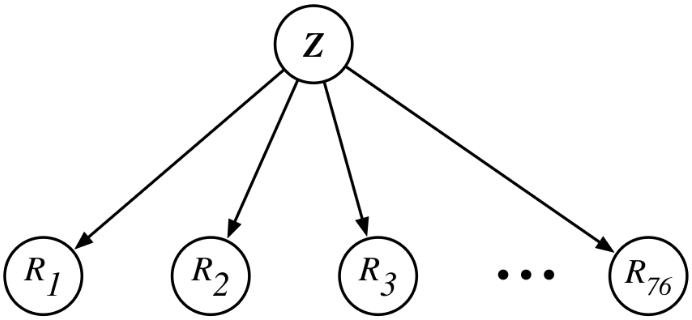

Let $\Omega_t$ denote the set of movies seen (and hence rated) by the $t$ th student.
The likelihood of the $t$ th student's ratings is given by:

$$
P\left( \{ R_j = r^{(t)}_j \}_{j \in \Omega_t} \right) =
\sum_{i=1}^k P(Z = i) \prod_{j \in \Omega_t} P\left( R_j = r^{(t)}_j \mid Z = i \right)
$$
This relation can be found by marginalizing the joint distribution between $Z$ and $\{ R_j = r^{(t)}_j \}_{j \in \Omega_t}$ and considering the fact that movie ratings $R_i$ are *conditionally independent* of each other given the type of movie watchers obtained from the Naive Bayes belief network and D - seperation criteria. 

Since we are interested in finding the hidden random variable $Z$ from the latent observations (partial observations), **Expectation Maximization** algorithmn is the most suitable way to get. The EM algorithmn maximizes the log likelihood of the observed data 
$$\mathcal{L} = \frac{1}{T}\sum_{t = 1}^T\log P\left( \{ R_j = r^{(t)}_j \}_{j \in \Omega_t} \right)$$
EM algorithmn consist of two steps **Expectation step** and **Maximization step**. 

The expectation step involves finding the expected value of the log likelihood function of the observed data which needs to be maximized. For that, we need the posterior probability $P(Z_i=1|\{ R_j = r^{(t)}_j \}_{j \in \Omega_t})$. By expanding and using the concepts seen above, we get
$$P(Z_i=1|\{ R_j = r^{(t)}_j \}_{j \in \Omega_t}) = \frac{
P(Z = i) \prod_{j \in \Omega_t} P\left( R_j = r^{(t)}_j \mid Z = i \right)
}{
\sum_{i'=1}^k P(Z = i') \prod_{j \in \Omega_t} P\left( R_j = r^{(t)}_j \mid Z = i' \right)
}$$

The maximization step involves finding the parameter by maximizing the expected likelihood we found above. Let $\rho_{it} = P\left( Z = i \mid \{ R_j = r^{(t)}_j \}_{j \in \Omega_t} \right)$, then

$$
P(Z = i) \leftarrow \frac{1}{T} \sum_{t=1}^T \rho_{it}
$$

$$
P(R_j = 1 \mid Z = i) \leftarrow 
\frac{
\sum_{\{t \mid j \in \Omega_t\}} \rho_{it} \cdot \mathbb{I}(r^{(t)}_j = 1) + \sum_{\{t \mid j \notin \Omega_t\}} \rho_{it} \cdot P(R_j = 1 \mid Z = i)
}{
\sum_{t=1}^T \rho_{it}
}
$$

If we do second derivative test for the derived maximization parameter, we can observe that it will be negative - showing that EM algorithmn will ensure that it converges.

The files *hw7_movies.txt*, *hw7_ids.txt*, and *hw7_ratings.txt* contains a matrix of zeros, ones, and missing elements denoted by question marks.  The $\langle i,j\rangle^{\rm th}$ element in this matrix contains the $i^{\rm th}$ student's rating of the $j^{\rm th}$ movie, according to the following key:

1 - recommended, <br>
0 - not recommend, <br>
? - not seen.


In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import string
import numpy as np
import csv
import matplotlib.pyplot as plt

In [2]:
movie = pd.read_csv('hw7_movies-1.txt',names=['name'])
student = pd.read_csv('hw7_ids-2.txt',names=['id'])
rating = pd.read_csv('hw7_ratings-1.txt',sep=' ',header=None,na_values='?')
P_Rj_Z=pd.read_csv('hw7_probR_init.txt',sep='   ',header=None)
P_Z=np.loadtxt('hw7_probZ_init.txt')

## Mean popularity rating of each movie, given by 
$$ \frac{\text{number of students who recommended the movie}}{\text{number of students who saw the movie}} $$


In [ ]:
movie['mean_pop_rating']=rating.sum()/(rating.notna().sum())
print(movie.sort_values(by=['mean_pop_rating']))
P_Rj_Z=P_Rj_Z.values

                                                 name  mean_pop_rating
51                                     Justice League         0.418848
2                                  The Last Airbender         0.484848
56                 Batman v Superman: Dawn of Justice         0.513761
28                                      Suicide Squad         0.521552
41                               Ant-Man and the Wasp         0.579767
54                                               Solo         0.586207
29                                 The Shape of Water         0.589041
10                           Star Wars: The Last Jedi         0.589744
37                                 Terminator Genisys         0.603774
47                                       Wonder Woman         0.609244
59                                          Furious 7         0.612745
50                                                 It         0.637363
15                                   Star Trek Beyond         0.642202
5     

In [4]:
ratings_matrix=rating.values
rate_col=[] # Columns where ratings are available
rate=[] #Ratings for each student

for i in range (ratings_matrix.shape[0]):

    # To get the columns where ratings are available (non NaN values)
    rate_col.append(np.where(~np.isnan(ratings_matrix[i]))[0])

    #To get the ratings of each student
    rate.append(ratings_matrix[i][rate_col[i]].tolist())

In [5]:
def EMalgo(P_Rj_Z,P_Z,rating,rate_col,rate):

    # P_Z - 4x1, P_Rj_Z - 60x4, rating - 455x60

    # initialization

    iteration = np.power(2,9)+1;
    no_stud = rating.shape[0]

    P_Rj=np.zeros(no_stud)
    P_Rj_Z_student=np.zeros((no_stud,P_Z.shape[0]))
    log_likelihood =np.zeros(iteration)

    P_Z_Rj = np.zeros((no_stud,P_Z.shape[0]))


    # iteration
    for i in range(iteration):

        # Model evaluation - likelihood evaluation

        for j in range (no_stud):

            #calculating P_Rj=1_Z and P_Rj=0_Z

            P_rj_1_z = (P_Rj_Z[rate_col[j]].T*rate[j]).T
            P_rj_0_z = ((1-P_Rj_Z[rate_col[j]]).T*(1-np.array(rate[j]))).T;

            P_Rj_Z_student[j] = np.prod(P_rj_1_z+P_rj_0_z,axis=0)
            P_Rj[j]=np.dot(P_Z,P_Rj_Z_student[j])


        log_likelihood[i] = np.mean(np.log(P_Rj)) #1x1


        # Expectation step

        P_Z_Rj=((P_Rj_Z_student*P_Z).T/P_Rj).T  #Broadcast


        # Maximization step

        P_Z = np.sum(P_Z_Rj,axis=0)/no_stud

        P_Rj_Z_new=np.zeros(P_Rj_Z.shape)

        total = set([i for i in range(P_Rj_Z.shape[0])])

        for j in range(no_stud):

            P_Rj_Z_new[rate_col[j]] = P_Rj_Z_new[rate_col[j]] + np.outer(rate[j],P_Z_Rj[j])

            other_indices = list(total - set(rate_col[j]))

            P_Rj_Z_new[other_indices] = P_Rj_Z_new[other_indices] + P_Rj_Z[other_indices]*P_Z_Rj[j]

        P_Rj_Z=P_Rj_Z_new/np.sum(P_Z_Rj,axis=0)


    index = [0]+[1* 2**i for i in range(9)]
    print(pd.DataFrame({'Iteration': index,'log likelihood L': log_likelihood[index]}))

    return P_Rj_Z,P_Z

In [6]:
[P_Rj_Z_up,P_Z_up]=EMalgo(P_Rj_Z,P_Z,ratings_matrix,rate_col,rate)

   Iteration  log likelihood L
0          0        -28.089322
1          1        -16.446668
2          2        -14.512416
3          4        -13.568216
4          8        -13.191756
5         16        -13.020406
6         32        -12.976600
7         64        -12.951366
8        128        -12.948196
9        256        -12.947038


In [7]:
result = student.query('id == "A69030950"')
rating.iloc[result.index]

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
203,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,1.0,0.0,NaN,1.0,1.0,1.0,1.0,NaN


Now after getting the parameters of the belief network, we can noe find recommendation for a partial preference list by a user by using the following 

For $\ell \notin \Omega_t$:

$$
P\left(R_\ell = 1 \mid \{ R_j = r^{(t)}_j \}_{j \in \Omega_t} \right) =
\sum_{i=1}^k
P\left( Z = i \mid \{ R_j = r^{(t)}_j \}_{j \in \Omega_t} \right)
\cdot P(R_\ell = 1 \mid Z = i)
$$


In [ ]:
def recommendation(P_Rj_Z,P_Z,rate_col,rate,index):
    total = set([i for i in range(P_Rj_Z.shape[0])])
    other_indices = list(total - set(rate_col[index]))

    P_rj_1_z = (P_Rj_Z[rate_col[index]].T*rate[index]).T
    P_rj_0_z = ((1-P_Rj_Z[rate_col[index]]).T*(1-np.array(rate[index]))).T

    P_Rj_Z_student = np.prod(P_rj_1_z+P_rj_0_z,axis=0) #4x1
    P_Rj=np.dot(P_Z,P_Rj_Z_student) # 1x1

    P_Z_Rj=(P_Rj_Z_student*P_Z)/P_Rj  #4x1

    P_rl_Rj = np.sum(P_Z_Rj*P_Rj_Z[other_indices],axis=1)

    print(pd.DataFrame({'Unseen movie': movie['name'].iloc[other_indices],'Expected rating': P_rl_Rj}).sort_values(by=['Expected rating'],ascending=False))

In [9]:
index = 203
recommendation(P_Rj_Z_up,P_Z_up,rate_col,rate,index)

            Unseen movie  Expected rating
14            The Matrix         0.981614
18            Deadpool 2         0.963534
54                  Solo         0.924165
3       The Hunger Games         0.921628
44  The Greatest Showman         0.902468
23                  Tron         0.870482
25                 Moana         0.844395
9             La La Land         0.843510
32                Frozen         0.843301
34            Ex Machina         0.837664
15      Star Trek Beyond         0.824482
40                  Coco         0.814979
45        The Lego Movie         0.731816
50                    It         0.723292
59             Furious 7         0.715460
2     The Last Airbender         0.671735
51        Justice League         0.654893
29    The Shape of Water         0.515080


Yes, this recommendation suits my taste